# 1. Read me first

## 1.1. OSR dataset

To use your own OOD dataset for evaluation, navigate to the last section in the notebook.

📍 "7. Evaluation - Unknown Dataset" You will find there:

'osr_dataset = []'

Replace the [] with your own OOD Dataset.

## 1.2. Choosing training or evaluation mode

To set whether the program runs in training or evaluation mode, navigate to:

📍 2. General → 2.3. Training or Evaluation Boolean

You will find there boolean variable 'eval_mode' that controls the mode selection.

# 2. General


## 2.1. Names and IDs:




*   Yoav Schwammenthal

## 2.2. Required Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset, ConcatDataset
from torchvision import datasets, transforms
from torchvision.transforms import (
    ToTensor,
    Normalize,
    Resize,
    RandomAffine,
    GaussianBlur,
    Grayscale
)
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.manifold import TSNE
import warnings
import matplotlib.patches as mpatches
import random
warnings.filterwarnings('ignore')

## 2.3. Training or Evaluation boolean

In [2]:
eval_mode = False

# 3. Project_utils:

In [3]:
# OSR Dataset template
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10



def eval_model(model, data_loader, device):
    """ Evaluation function for the OSR task.
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both.
    Note - this function does NOT computes the MNIST baseline accruacy.
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """

    # Ensure model is in evaluation mode
    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    # No need to track gradients for evaluation, saves memory and computations
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            ### Modify output if needed ###
            data = data.view(-1, 28*28)
            # Model outputs
            outputs = model(data)


            # y pred should be a vector of size (N_batch,) -> [5, 2, ..., 10]
            # and not one-hot. You can handle this either in your model or here.

            # Assuming the model returns an (N_batch, 11) size output
            probas, y_pred = torch.max(outputs, 1)

            # Split MNIST and OOD predictions and labels
            # Assuming numerical labels, which is MNIST/CIFAR datasets default
            # Note: Not one-hot!
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            pred_mnist = y_pred[mask_mnist]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total


# # Usaged example
# # Load the MNIST and OOD datasets
# # Define the transformations
# transform = transforms.Compose([ToTensor()])


# mnist = MNIST(root='./data', train=False, download=True, transform=transform)
# ood = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# # sample ~500-1000 samples from CIFAR/FashionMNIST
# # ... #
# # Combine the datasets
# combined_ds = CombinedDataset(mnist, ood)
# # large batchsize for inference is recommended
# batch_size = 1024
# data_loader = DataLoader(combined_ds, batch_size=batch_size, shuffle=True)


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # Placeholder model
# model = nn.Sequential(nn.Linear(28*28, 10))
# model.to(device)

# acc_mnist, acc_ood, acc_total = eval_model(model, data_loader, device)
# print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
# print(f'OOD Accuracy: {acc_ood*100:.2f}%')
# print(f'Total Accuracy: {acc_total*100:.2f}%')


# 4. Data & Preprocessing

## 4.1 Random seeds (for reproducibility) & cuda

In [4]:
# Set all random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 4.2 Dataset Preprocessing, Augmentation & DataLoaders

In [5]:
################################################################################
#                       Computing Dataset Statistics                            #
################################################################################
# This function computes the mean and standard deviation of the MNIST dataset.
# These values are used for normalization to ensure stable model training.
################################################################################

def compute_mnist_stats(train_dataset):
    """Compute mean and standard deviation of the MNIST training set."""
    loader = DataLoader(train_dataset, batch_size=1000)
    mean = 0.
    std = 0.
    total_samples = 0

    print("Computing dataset statistics...")
    for images, _ in tqdm(loader):
        batch_samples = images.size(0)
        images = images.view(batch_samples, -1)  # Flatten images
        mean += images.mean(1).sum()
        std += images.std(1).sum()
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    return mean.item(), std.item()

# Compute mean and standard deviation using the raw MNIST training set (without normalization)
raw_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
train_mean, train_std = compute_mnist_stats(raw_mnist)


################################################################################
#                        Dataset Classes and Transforms                         #
################################################################################
# Custom transformations are defined here, including a class to prevent incorrect
# rotations of digits (e.g., 6 and 9) and a dataset augmentation class.
################################################################################

class SmartRotation:
    """Custom rotation transformation that prevents flipping 6 and 9."""

    def __init__(self, degrees=15):
        self.degrees = degrees

    def __call__(self, x):
        # If image is passed as a tuple (image, label), extract the label
        digit = None
        if isinstance(x, tuple):
            x, digit = x

        # Reduce rotation for digits 6 and 9 to avoid misclassification
        if digit in [6, 9]:
            angle = float(torch.empty(1).uniform_(-self.degrees/3, self.degrees/3))
        else:
            angle = float(torch.empty(1).uniform_(-self.degrees, self.degrees))

        return transforms.functional.rotate(x, angle)


class AugmentedMNIST(Dataset):
    """Applies data augmentation to MNIST images to improve model robustness."""

    def __init__(self, base_dataset, num_augmentations=2):
        self.base_dataset = base_dataset
        self.num_augmentations = num_augmentations

        # Random augmentation pipeline
        self.transform = transforms.Compose([
            transforms.RandomApply([
                GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                SmartRotation(degrees=30),
                RandomAffine(
                    degrees=0,
                    translate=(0.1, 0.1),
                    scale=(0.8, 1.2),
                    fill=0
                )
            ], p=0.5),
            Resize((28, 28)),
            Normalize((train_mean,), (train_std,))
        ])

    def __len__(self):
        return len(self.base_dataset) * self.num_augmentations

    def __getitem__(self, idx):
        base_idx = idx // self.num_augmentations
        image, label = self.base_dataset[base_idx]

        # Apply augmentation only to the additional copies (not the first copy)
        if idx % self.num_augmentations != 0:
            image = self.transform(image)

        return image, label


# Define mandatory transformations applied to all datasets
mandatory_transforms = transforms.Compose([
    ToTensor(),
    Normalize((train_mean,), (train_std,)),
    Resize((28, 28))
])

# Define transformations for Out-of-Distribution (OOD) datasets (convert to grayscale)
ood_transform = transforms.Compose([
    ToTensor(),
    Grayscale(num_output_channels=1),
    Normalize((train_mean,), (train_std,)),
    Resize((28, 28))
])


################################################################################
#                          Dataset Preparation                                  #
################################################################################
# MNIST is used for training, validation, and testing.
# CIFAR10 and FashionMNIST are used only for evaluation as Out-of-Distribution (OOD) datasets.
################################################################################

# ---------------- Training & Validation Datasets ----------------
train_full = datasets.MNIST(root='./data', train=True, download=True, transform=mandatory_transforms)

# Split into 80% training and 20% validation
train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_dataset, val_dataset = random_split(
    train_full, [train_size, val_size], generator=torch.Generator().manual_seed(RANDOM_SEED)
)

# Augment training dataset
augmented_train_dataset = AugmentedMNIST(train_dataset, num_augmentations=3)

# ---------------- Testing & OSR Datasets ----------------
# Standard MNIST test set
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=mandatory_transforms)

# Load CIFAR-10 and FashionMNIST as OOD datasets
cifar_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=ood_transform)
fashion_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=ood_transform)

# Sample 1000 images from each OOD dataset
ood_sample_size = 1000
cifar_subset = Subset(cifar_dataset, torch.randperm(len(cifar_dataset))[:ood_sample_size])
fashion_subset = Subset(fashion_dataset, torch.randperm(len(fashion_dataset))[:ood_sample_size])

# Combine OOD subsets into one dataset (2000 samples total)
ood_combined = ConcatDataset([cifar_subset, fashion_subset])
combined_osr_dataset = CombinedDataset(mnist=test_dataset, ood=ood_combined)
# =======================================================================================

################################################################################
#                          DataLoader Creation                                  #
################################################################################
# Create PyTorch DataLoaders for efficient batch processing.
################################################################################

BATCH_SIZE = 128
loader_kwargs = {'batch_size': BATCH_SIZE, 'num_workers': 2, 'pin_memory': True}

train_loader = DataLoader(augmented_train_dataset, shuffle=True, **loader_kwargs)
val_loader = DataLoader(val_dataset, shuffle=False, **loader_kwargs)
test_loader = DataLoader(test_dataset, shuffle=False, **loader_kwargs)
osr_loader = DataLoader(combined_osr_dataset, shuffle=False, **loader_kwargs)


################################################################################
#                    Print Final Dataset Details and Sizes                     #
################################################################################

train_aug_len = len(augmented_train_dataset)
val_len = len(val_dataset)
test_len = len(test_dataset)
osr_len = len(combined_osr_dataset)

cifar_len = len(cifar_subset)
fashion_len = len(fashion_subset)
ood_total_len = cifar_len + fashion_len

print("\nFinal Datasets:")
print(f"1. Baseline Training Dataset (Augmented MNIST): {train_aug_len} samples")
print(f"2. Baseline Validation Dataset (MNIST): {val_len} samples")
print(f"3. Baseline Test Dataset (MNIST): {test_len} samples")
print(f"4. OSR Test Dataset (MNIST Test + OOD): {osr_len} samples")
print(f"   - MNIST Test portion: {test_len}")
print(f"   - OOD portion (CIFAR10 + FashionMNIST): {ood_total_len}  [CIFAR10={cifar_len}, FashionMNIST={fashion_len}]\n")


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.23MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.44MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.51MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Computing dataset statistics...


  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 170M/170M [00:16<00:00, 10.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


100%|██████████| 26.4M/26.4M [00:03<00:00, 7.41MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 115kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:02<00:00, 2.19MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.5MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Final Datasets:
1. Baseline Training Dataset (Augmented MNIST): 144000 samples
2. Baseline Validation Dataset (MNIST): 12000 samples
3. Baseline Test Dataset (MNIST): 10000 samples
4. OSR Test Dataset (MNIST Test + OOD): 12000 samples
   - MNIST Test portion: 10000
   - OOD portion (CIFAR10 + FashionMNIST): 2000  [CIFAR10=1000, FashionMNIST=1000]



## 4.3 Visualizing Dataset Distribution & Sample Images

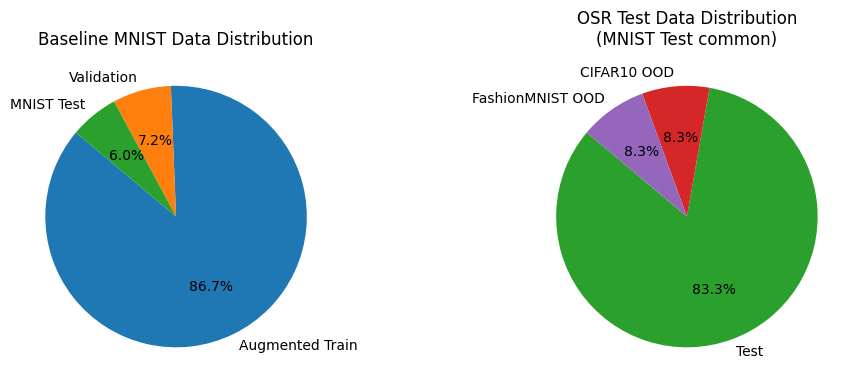


Visualizing Baseline Training Dataset Samples:


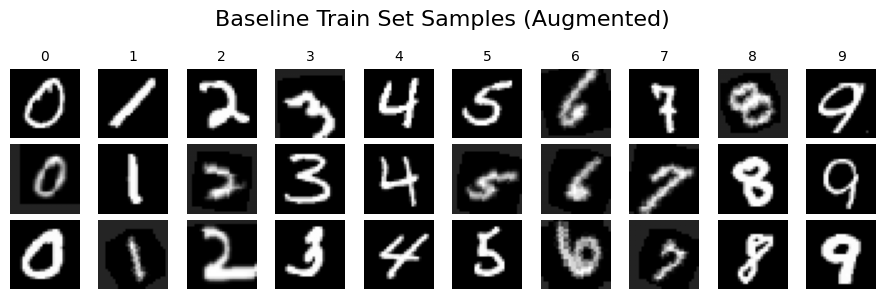


Visualizing Baseline Test Dataset Samples:


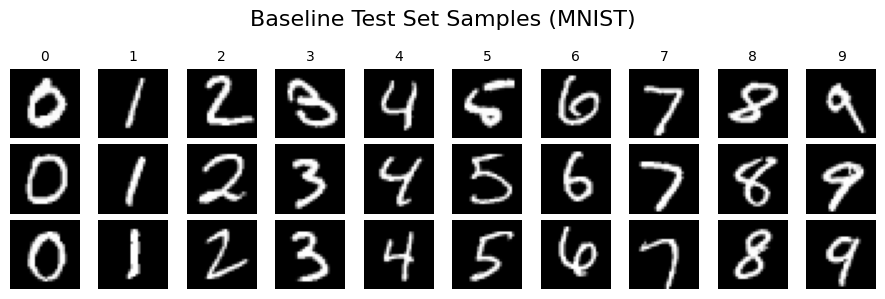


Visualizing OSR Test Dataset Samples:


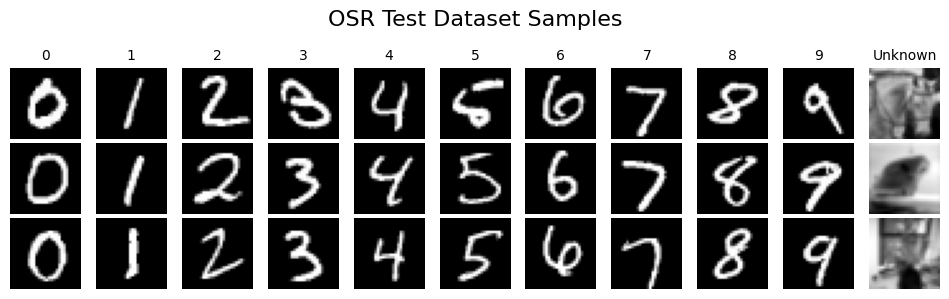

In [6]:
################################################################################
#                       Create "Cake" (Pie) Charts                              #
################################################################################
# This section creates two pie charts:
# 1) The distribution of the MNIST dataset (Train, Validation, Test).
# 2) The OSR dataset distribution (MNIST Test + Out-of-Distribution (OOD) Samples).
################################################################################

def create_pie_charts(train_aug_size, val_size, test_size, test_mnist_size, cifar_size, fashion_size):
    """
    Creates two pie charts:
    1) Baseline MNIST data distribution:
         - Augmented Train, Validation, MNIST Test.
    2) OSR Test data distribution:
         - MNIST Test (common), CIFAR10 OOD, FashionMNIST OOD.
    The MNIST Test slice is assigned the same color in both charts.
    """
    # Define labels and sizes for MNIST dataset
    baseline_labels = ["Augmented Train", "Validation", "MNIST Test"]
    baseline_sizes = [train_aug_size, val_size, test_size]
    baseline_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Colors for Train, Val, Test

    # Define labels and sizes for OSR dataset (OOD + MNIST Test)
    osr_labels = ["Test", "CIFAR10 OOD", "FashionMNIST OOD"]
    osr_sizes = [test_mnist_size, cifar_size, fashion_size]
    osr_colors = ["#2ca02c", "#d62728", "#9467bd"]  # Colors for MNIST Test, CIFAR-10, FashionMNIST

    # Create and display pie charts
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].pie(baseline_sizes, labels=baseline_labels, autopct="%1.1f%%", startangle=140, colors=baseline_colors)
    ax[0].set_title("Baseline MNIST Data Distribution")

    ax[1].pie(osr_sizes, labels=osr_labels, autopct="%1.1f%%", startangle=140, colors=osr_colors)
    ax[1].set_title("OSR Test Data Distribution\n(MNIST Test common)")

    plt.tight_layout()
    plt.show()

# Generate the two pie charts
create_pie_charts(
    train_aug_len,   # Augmented Train dataset size
    val_len,         # Validation dataset size
    test_len,        # MNIST Test dataset size (baseline)
    test_len,        # MNIST Test portion in OSR (same as baseline)
    cifar_len,       # CIFAR10 OOD portion
    fashion_len      # FashionMNIST OOD portion
)


################################################################################
#                          Data Visualization                                   #
################################################################################
# This section visualizes samples from:
# 1) The MNIST Training set
# 2) The MNIST Test set
# 3) The OSR dataset (MNIST Test + OOD)
################################################################################

def visualize_samples(loader, title):
    """
    Visualizes samples from a DataLoader containing only MNIST images.
    - Displays 3 examples per digit (0-9).
    - Arranged in a 3-row × 10-column grid.
    """
    samples_per_class = {i: [] for i in range(10)}  # Collect images per digit

    for images, labels in loader:
        for img, lbl in zip(images, labels):
            if lbl.item() in samples_per_class and len(samples_per_class[lbl.item()]) < 3:
                samples_per_class[lbl.item()].append(img)
        if all(len(samples) >= 3 for samples in samples_per_class.values()):
            break

    # Create figure and plot images
    fig, axes = plt.subplots(3, 10, figsize=(9, 3))
    fig.suptitle(title, fontsize=16)
    for col in range(10):
        for row in range(3):
            axes[row, col].imshow(samples_per_class[col][row].squeeze().cpu().numpy(), cmap='gray')
            axes[row, col].axis('off')
            if row == 0:
                axes[row, col].set_title(f"{col}", fontsize=10)
    plt.tight_layout()
    plt.show()


def visualize_osr_samples(mnist_loader, ood_loader, samples_per_class=3):
    """
    Visualizes Open Set Recognition (OSR) samples.
    - First 10 columns show MNIST digits (0-9).
    - Last column (11th) shows Out-of-Distribution (OOD) samples.
    """
    mnist_samples = {i: [] for i in range(10)}

    # Collect MNIST samples
    for images, labels in mnist_loader:
        for img, lbl in zip(images, labels):
            if len(mnist_samples[lbl.item()]) < samples_per_class:
                mnist_samples[lbl.item()].append(img)
        if all(len(samples) >= samples_per_class for samples in mnist_samples.values()):
            break

    # Collect OOD samples
    ood_samples = []
    for images, _ in ood_loader:
        for img in images:
            if len(ood_samples) < samples_per_class:
                ood_samples.append(img)
        if len(ood_samples) >= samples_per_class:
            break

    # Create figure and plot images
    fig, axes = plt.subplots(samples_per_class, 11, figsize=(9.6, 3))
    fig.suptitle("OSR Test Dataset Samples", fontsize=16)

    for row in range(samples_per_class):
        # MNIST columns (0-9)
        for col in range(10):
            axes[row, col].imshow(mnist_samples[col][row].squeeze().cpu().numpy(), cmap='gray')
            axes[row, col].axis('off')
            if row == 0:
                axes[row, col].set_title(f"{col}", fontsize=10)

        # OOD column (Unknown)
        axes[row, 10].imshow(ood_samples[row].squeeze().cpu().numpy(), cmap='gray')
        axes[row, 10].axis('off')
        if row == 0:
            axes[row, 10].set_title("Unknown", fontsize=10)

    plt.tight_layout()
    plt.show()


################################################################################
#                    Visualize Final Dataset Samples                           #
################################################################################
# Generate visualizations for different dataset splits
################################################################################

# 1. Visualize MNIST Training Dataset (Augmented)
print("\nVisualizing Baseline Training Dataset Samples:")
visualize_samples(train_loader, "Baseline Train Set Samples (Augmented)")

# 2. Visualize MNIST Test Dataset
print("\nVisualizing Baseline Test Dataset Samples:")
visualize_samples(test_loader, "Baseline Test Set Samples (MNIST)")

# 3. Visualize OSR Dataset (MNIST Test + OOD Samples)
print("\nVisualizing OSR Test Dataset Samples:")
visualize_osr_samples(test_loader, DataLoader(ood_combined, batch_size=10, shuffle=False))


# 5. Model | Training | Vizualization

## 5.1 Configuration Variables

In [7]:
################################################################################
#                              Configuration                                     #
################################################################################

# Training parameters
NUM_EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.01

# Model architecture
EMBEDDING_DIM = 128
DROPOUT_RATE = 0.5
CONV_DROPOUT = 0.25

# Cluster fitting
CLUSTER_PERCENTILE = 90  # Percentile for determining cluster radius

## 5.2 Plot & Visualization Functions

In [8]:
def plot_training_curves(train_losses, train_accs, val_losses, val_accs):
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Loss plot
        ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
        ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
        ax1.set_title('Loss Curves')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.set_xticks(range(1, len(train_losses) + 1))  # Only integer epoch numbers

        # Accuracy plot
        ax2.plot(range(1, len(train_accs) + 1), train_accs, label='Train Acc')
        ax2.plot(range(1, len(val_accs) + 1), val_accs, label='Val Acc')
        ax2.set_title('Accuracy Curves')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.set_xticks(range(1, len(train_accs) + 1))  # Only integer epoch numbers

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting training curves: {e}")


def plot_confusion_matrix(y_true, y_pred, classes, title):
    """ Plots a confusion matrix with percentage values. """
    try:
        cm = confusion_matrix(y_true, y_pred, labels=classes, normalize="true") * 100  # Convert to percentages

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues",
                    xticklabels=classes, yticklabels=classes)

        plt.title(f"{title} (Percentages)")
        plt.xlabel("Predicted")
        plt.ylabel("True")

        cbar = plt.gca().collections[0].colorbar
        cbar.set_ticks(range(0, 110, 10))  # Show 0, 10, 20, ..., 100%

        plt.show()
    except Exception as e:
        print(f"Error plotting confusion matrix: {e}")

def plot_confusion_matrices(predictions, labels, accuracy, baseline=False):
    try:
        # Normalize confusion matrix to percentages
        cm = confusion_matrix(labels, predictions, normalize='true') * 100  # Convert to percentage

        if baseline:
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                        xticklabels=list(range(10)), yticklabels=list(range(10)))
            plt.title(f"Baseline Model - MNIST Confusion Matrix [%]\nAccuracy: {accuracy:.2f}%")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.show()
        else:
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))

            sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", ax=axes[0],
                        xticklabels=list(range(11)), yticklabels=list(range(11)))
            axes[0].set_title(f"OSR Model - Full Confusion Matrix (MNIST + Unknown) [%]\nAccuracy: {accuracy:.2f}%")
            axes[0].set_xlabel("Predicted")
            axes[0].set_ylabel("True")

            # Binary confusion matrix (Known vs Unknown)
            binary_true = (labels == 10).astype(int)
            binary_pred = (predictions == 10).astype(int)
            cm_binary = confusion_matrix(binary_true, binary_pred, normalize='true') * 100

            sns.heatmap(cm_binary, annot=True, fmt=".2f", cmap="Blues", ax=axes[1],
                        xticklabels=['Known', 'Unknown'], yticklabels=['Known', 'Unknown'])
            axes[1].set_title(f"OSR Model - Known vs Unknown Confusion Matrix [%]\nAccuracy: {accuracy:.2f}%")
            axes[1].set_xlabel("Predicted")
            axes[1].set_ylabel("True")

            # Adjust color bar ticks to show 0, 10, 20, ..., 100
            for ax in axes:
                cbar = ax.collections[0].colorbar
                cbar.set_ticks(range(0, 110, 10))

            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error plotting confusion matrices: {e}")


def visualize_embeddings(model, loader, device):
    try:
        model.eval()
        model.force_training = True  # Prevent unknown detection during embedding collection
        embeddings = []
        labels = []

        with torch.no_grad():
            for data, target in tqdm(loader, desc="Collecting embeddings"):
                data, target = data.to(device), target.to(device)
                _, embedding = model(data, return_embedding=True)
                embeddings.append(embedding.cpu().numpy())
                labels.append(target.cpu().numpy())

        embeddings = np.concatenate(embeddings)
        labels = np.concatenate(labels)

        tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
        embeddings_2d = tsne.fit_transform(embeddings)

        plt.figure(figsize=(10, 8))

        # **Keep original class-based coloring for dots**
        scatter = plt.scatter(
            embeddings_2d[:, 0], embeddings_2d[:, 1],
            c=labels, cmap='tab20', alpha=0.6
        )

        # **Create a legend with the same class colors**
        num_classes = 11  # Includes OOD class
        colors = plt.cm.tab20(np.linspace(0, 1, num_classes))
        legend_patches = [mpatches.Patch(color=colors[i], label=f"Class {i}") for i in range(num_classes)]

        plt.legend(handles=legend_patches, title="Classes", loc="best")

        plt.title('t-SNE Visualization of Embeddings')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.show()

    except Exception as e:
        print(f"Error visualizing embeddings: {e}")

    finally:
        model.force_training = False  # Reset the flag


def print_final_results(baseline_acc, osr_mnist_acc, osr_ood_acc, osr_total_acc):
    print("\n========================================\n")
    print("            Final Results  ")
    print("\n========================================\n")
    print(f"MNIST Accuracy (Baseline): {baseline_acc:.2f}%")
    print(f"MNIST Accuracy (OSR): {osr_mnist_acc:.2f}%")
    print(f"OOD Accuracy: {osr_ood_acc:.2f}%")
    print(f"Total OSR Accuracy: {osr_total_acc:.2f}%")

## 5.3 Model Class & Training Function

In [9]:
class OSRmodel(nn.Module):
    def __init__(self, embedding_dim=EMBEDDING_DIM):
        super(OSRmodel, self).__init__()

        self.encoder = nn.Sequential(
            # Convolutional Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(CONV_DROPOUT),

            # Convolutional Block 2
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Dense layers
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(512, embedding_dim)
        )

        # Classifier for all 11 classes (0-9 + unknown)
        self.classifier = nn.Linear(embedding_dim, 11)

        # Store cluster centers and radiuses
        self.register_buffer('cluster_centers', torch.zeros(10, embedding_dim))
        self.register_buffer('cluster_radiuses', torch.zeros(10))

        # Flag to force training behavior (used in validation)
        self.force_training = False

    def forward(self, x, return_embedding=False, baseline_mode=False):
        # Handle input shape
        if x.dim() == 2:  # If input is flattened (batch_size, 784)
            x = x.view(-1, 1, 28, 28)

        # Get embedding
        embedding = self.encoder(x)

        # Get logits for all 11 classes
        logits = self.classifier(embedding)

        # Baseline mode: return logits without cluster-based rejection
        if baseline_mode:
            return logits if not return_embedding else (logits, embedding)

        # OSR mode: Modify logits based on clustering distances
        if not self.training and not self.force_training:
            distances = torch.cdist(embedding, self.cluster_centers)

            # Check if point falls within ANY cluster's radius
            within_any_cluster = (distances <= self.cluster_radiuses.unsqueeze(0)).any(dim=1)
            unknown_mask = ~within_any_cluster

            # Adjust logits for unknown class
            if unknown_mask.any():
                logits[unknown_mask, :10] = -1e9  # Suppress known classes
                logits[unknown_mask, 10] = 1e9    # Boost unknown class

        return logits if not return_embedding else (logits, embedding)


    def fit_clusters(self, train_loader, device):
        """
        Fits a K-means cluster for each MNIST digit (0-9) in the embedding space.
        Each cluster represents the "normal" region for that digit.
        These clusters are used during inference to detect unknown samples.

        Process:
        1. Collects embeddings for each digit class from the training data
        2. Fits a single centroid for each digit class
        3. Calculates the radius for each cluster based on distance distribution
        """

        self.eval()
        self.force_training = True  # Prevent unknown detection during embedding collection
        embeddings_by_class = {i: [] for i in range(10)}

        try:
            # Step 1: Collect embeddings for each class
            with torch.no_grad():
                for data, target in tqdm(train_loader, desc="Collecting embeddings"):
                    data, target = data.to(device), target.to(device)
                    _, embeddings = self.forward(data, return_embedding=True)

                    # Group embeddings by digit class
                    for i in range(10):
                        mask = target == i # Find all samples of current digit
                        if mask.any():
                            embeddings_by_class[i].append(embeddings[mask].cpu().numpy())

            # Step 2 & 3: Fit clusters and calculate radiuses
            for digit in range(10):
                # Combine all embeddings for current digit
                digit_embeddings = np.concatenate(embeddings_by_class[digit])

                # Fit K-means with single cluster (k=1) to find centroid
                kmeans = KMeans(n_clusters=1, random_state=RANDOM_SEED)
                kmeans.fit(digit_embeddings)

                # Store cluster center
                self.cluster_centers[digit] = torch.tensor(
                    kmeans.cluster_centers_[0],
                    device=device
                )

                # Calculate distances of all points to cluster center
                distances = np.linalg.norm(
                    digit_embeddings - kmeans.cluster_centers_[0],
                    axis=1
                )

                # Set radius as the value stored in variable 'percentile' of distances
                # Points beyond this radius will be considered unknown
                self.cluster_radiuses[digit] = torch.tensor(
                    np.percentile(distances, CLUSTER_PERCENTILE),
                    device=device
                )
        finally:
            self.force_training = False  # Reset the flag

def train_model(model, train_loader, val_loader, device, num_epochs=NUM_EPOCHS):
    """
    Trains the model using CrossEntropyLoss and AdamW optimizer.
    Uses cosine annealing learning rate scheduling for better convergence.

    Training process:
    1. For each epoch:
        - Train on training data
        - Validate on validation data
        - Update learning rate
    2. Saves model weights and returns training history

    Note: Only trains on MNIST classes (0-9), doesn't use unknown class during training
    """
    if not eval_mode:
        # Setup loss, optimizer and scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        # Lists to store training history
        train_losses, train_accs = [], []
        val_losses, val_accs = [], []

        # Create ONE tqdm progress bar for all epochs
        total_batches = num_epochs * len(train_loader)  # Total number of iterations
        pbar = tqdm(total=total_batches, desc=f"Training (Epoch 1/{num_epochs})", position=0, leave=True)

        try:
            for epoch in range(num_epochs):
                # Training phase
                model.train()
                model.force_training = False  # Use normal training behavior
                train_loss = 0
                correct = 0
                total = 0

                for data, target in train_loader:
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    outputs = model(data)
                    loss = criterion(outputs[:, :10], target)  # Only use first 10 classes during training

                    # Backpropagation
                    loss.backward()
                    optimizer.step()

                    # Calculate training statistics
                    train_loss += loss.item()
                    pred = outputs[:, :10].argmax(dim=1)
                    correct += pred.eq(target).sum().item()
                    total += len(target)

                    # Update progress bar and dynamically show the epoch number
                    pbar.update(1)
                    pbar.set_description(f"Training (Epoch {epoch+1}/{num_epochs})")

                # Calculate average training metrics
                train_loss /= len(train_loader)
                train_acc = correct / total

                # Validation
                model.eval()
                model.force_training = True # Disable unknown detection during validation
                val_loss = 0
                correct = 0
                total = 0

                with torch.no_grad():
                    for data, target in val_loader:
                        data, target = data.to(device), target.to(device)
                        outputs = model(data)
                        val_loss += criterion(outputs[:, :10], target).item()
                        pred = outputs[:, :10].argmax(dim=1)
                        correct += pred.eq(target).sum().item()
                        total += len(target)

                # Calculate average validation metrics
                val_loss /= len(val_loader)
                val_acc = correct / total

                # Update learning rate
                model.force_training = False
                scheduler.step()

                # Store metrics for plotting
                train_losses.append(train_loss)
                train_accs.append(train_acc)
                val_losses.append(val_loss)
                val_accs.append(val_acc)

            pbar.close()  # Close progress bar at end of training

            # Save final model
            torch.save(model.state_dict(), 'embedding_model.pth')

            # Plot training curves
            return model, train_losses, train_accs, val_losses, val_accs


        except Exception as e:
            print(f"Error during training: {e}")

        finally:
            model.force_training = False  # Ensure flag is reset

    return model



## 5.4 Evaluation functions for Baseline & OSR Models

In [10]:
def evaluate_baseline(model, test_loader, device):
    """
    Evaluates the baseline performance on MNIST test set without OSR detection.
    Only evaluates the model's ability to classify MNIST digits (0-9).

    Args:
        model: The trained model
        test_loader: DataLoader containing MNIST test data
        device: Device to run evaluation on (cuda/cpu)

    Process:
    1. Sets model to eval mode
    2. Forward passes test data with baseline_mode=True to disable OSR detection
    3. Collects predictions and ground truth labels
    4. Computes overall accuracy

    Returns:
        accuracy: Classification accuracy as percentage
        all_preds: Array of model predictions
        all_labels: Array of true labels
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating Baseline Model"):
            data, target = data.to(device), target.to(device)
            outputs = model(data, baseline_mode=True)  # Disable cluster-based rejection (Disable OSR detection)
            predictions = outputs.argmax(dim=1) # Get predicted class (0-9)

            # Collect predictions and labels
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    # Convert to numpy arrays for computing metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = (all_preds == all_labels).mean() * 100  # Calculate accuracy percentage

    return accuracy, all_preds, all_labels  # Ensure all three values are returned


def evaluate_osr(model, osr_loader, device):
    """
    Evaluates the model's performance on both MNIST and out-of-distribution (OOD) data.
    Tests the model's ability to both classify MNIST digits and detect unknown samples.

    Args:
        model: The trained model
        osr_loader: DataLoader containing both MNIST and OOD data
        device: Device to run evaluation on (cuda/cpu)

    Process:
    1. Sets model to eval mode and enables OSR detection
    2. Forward passes combined MNIST+OOD data
    3. Collects predictions (0-10) and ground truth labels
    4. Computes separate accuracies for:
        - MNIST samples (0-9)
        - OOD samples (class 10)
        - Overall performance

    Returns:
        mnist_acc: Accuracy on MNIST samples
        ood_acc: Accuracy on OOD samples
        total_acc: Overall accuracy
        all_preds: Array of model predictions
        all_labels: Array of true labels
    """
    model.eval()
    model.force_training = False  # Enable OSR detection logic

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in tqdm(osr_loader, desc="Evaluating OSR Model"):
            data, target = data.to(device), target.to(device)
            outputs = model(data) # OSR detection enabled
            predictions = outputs.argmax(dim=1)  # 11 classes (0-9 + unknown)

            # Collect predictions and labels
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

   # Create masks for separating MNIST and OOD samples
    mnist_mask = all_labels < 10 # MNIST labels are 0-9
    ood_mask = all_labels == 10 # OOD label is 10

   # Compute separate accuracies
    mnist_acc = accuracy_score(all_labels[mnist_mask], all_preds[mnist_mask]) * 100
    ood_acc = accuracy_score(all_labels[ood_mask], all_preds[ood_mask]) * 100
    total_acc = accuracy_score(all_labels, all_preds) * 100

    return mnist_acc, ood_acc, total_acc, all_preds, all_labels


## 5.5 Main Pipeline Execution

In [11]:
################################################################################
#                     Model Training/Loading Pipeline                            #
################################################################################
"""
This section handles either:
1. Training a new model from scratch (if eval_mode=False)
2. Loading a pre-trained model for evaluation (if eval_mode=True)

Process for training new model:
1. Initialize OSR model and move to GPU/CPU
2. Train model on MNIST digits
3. Fit clusters for OSR detection
4. Save complete model with clusters

Process for evaluation:
1. Initialize OSR model
2. Load saved weights and cluster parameters
"""

# ========================================
print("\n========================================")
print("         1/3 Initializing Model...")
print("========================================\n")

# Create model instance and move to appropriate device
model = OSRmodel().to(device)

if not eval_mode:
    # Training Mode
    # ========================================
    print("\n========================================")
    print("          2/3 Training Model...")
    print("========================================\n")

    # Train model on MNIST dataset
    # Returns: trained model and training history for plotting
    model, train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader, device)

    # ========================================
    print("\n========================================")
    print(" 3/3 Fitting Clusters on Model Embeddings...")
    print("========================================\n")

    # Fit clusters for OSR detection using trained model's embeddings
    model.fit_clusters(train_loader, device)

    # Save complete model with clusters for future evaluation
    torch.save({
        'model_state_dict': model.state_dict(),
        'cluster_centers': model.cluster_centers,
        'cluster_radiuses': model.cluster_radiuses
    }, 'complete_model.pth')

else:
   # Evaluation Mode
    print("\n========================================")
    print("     Loading Trained Model for Evaluation...")
    print("========================================\n")

    # Load saved model and cluster parameters
    checkpoint = torch.load('complete_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])   # Load weights
    model.cluster_centers = checkpoint['cluster_centers']   # Load cluster centers
    model.cluster_radiuses = checkpoint['cluster_radiuses'] # Load cluster radiuses



         1/3 Initializing Model...


          2/3 Training Model...



Training (Epoch 1/10):   0%|          | 0/11250 [00:00<?, ?it/s]


 3/3 Fitting Clusters on Model Embeddings...



# 6. Evaluation

## 6.1 Loss & Accuracy Training Curves


     Training Performance Curves...



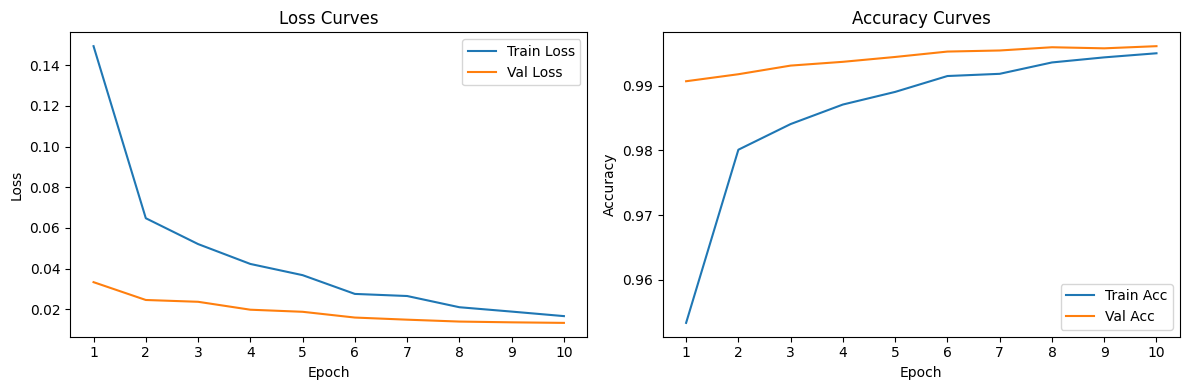

In [12]:
# ========================================
print("\n========================================")
print("     Training Performance Curves...")
print("========================================\n")

# Plot training curves
plot_training_curves(train_losses, train_accs, val_losses, val_accs)


## 6.2 Baseline Results (MNIST Accuracy & Confusion Matrix)


     Evaluating Baseline Model...



Evaluating Baseline Model:   0%|          | 0/79 [00:00<?, ?it/s]

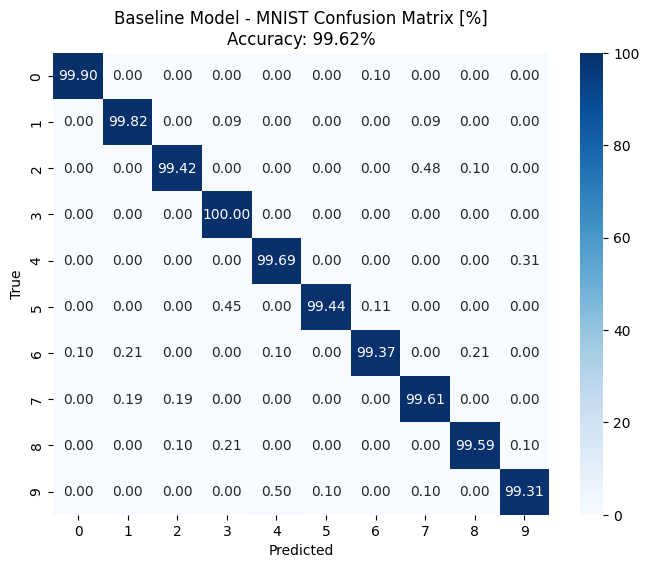

In [13]:
# ========================================
print("\n========================================")
print("     Evaluating Baseline Model...")
print("========================================\n")

baseline_acc, baseline_preds, baseline_labels = evaluate_baseline(model, test_loader, device)
plot_confusion_matrices(baseline_preds, baseline_labels, baseline=True, accuracy=baseline_acc)


## 6.3 OSR Approach Description

I utilized the fact that in a well-trained model, inputs of the same digit tend to be placed close to each other in the embedding space. By applying clustering techniques to these embeddings, we can identify regions that represent "normal" digit samples and detect unknown samples that fall outside these regions.

My implementation consists of a CNN backbone with two convolutional blocks that maps input images into a 128-dimensional embedding space through dense layers. The network uses batch normalization, ReLU activations, max pooling and dropout throughout.

After training the model on MNIST digits using cross-entropy loss, I fit a single K-means cluster (k=1) for each digit class in the embedding space. For each cluster, I calculate a radius threshold based on the 90th percentile of distances between training samples and their cluster center.

During inference:
1. The test image passes through the CNN to get its embedding
2. Distances are computed between this embedding and all digit cluster centers
3. The embedding is checked against all cluster radiuses - if it falls within any cluster's radius, it's considered a known digit
4. If the embedding falls outside all cluster radiuses, it's marked as unknown by adjusting the logits
5. For known samples, the regular classifier output determines the digit class

## 6.4 OSR Evaluation

In [14]:
# ========================================
print("\n========================================")
print("      Evaluating OSR Model...")
print("========================================\n")

acc_mnist, acc_ood, acc_total = eval_model(model, osr_loader, device)
print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')



      Evaluating OSR Model...

MNIST Accuracy: 95.14%
OOD Accuracy: 96.10%
Total Accuracy: 95.30%


## 6.5 OSR Confusion Matrices (Full & Binary)


      OSR Results: Full Confusion Matrix...



Evaluating OSR Model:   0%|          | 0/94 [00:00<?, ?it/s]

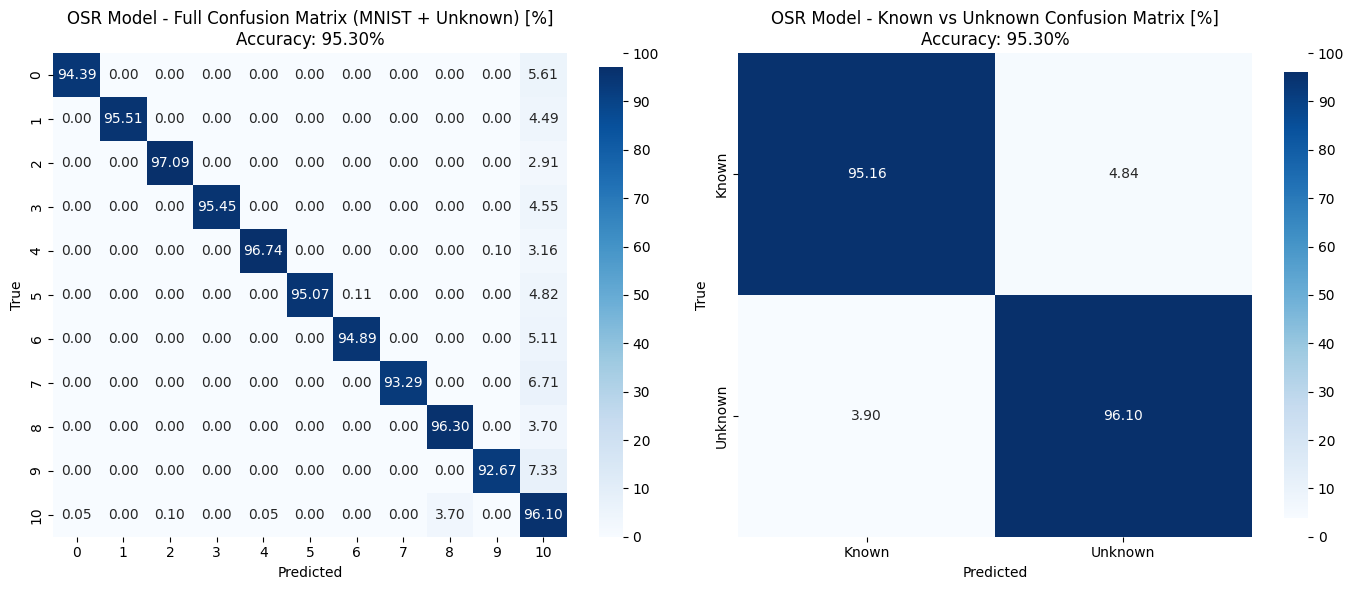

In [15]:
# ========================================
print("\n========================================")
print("      OSR Results: Full Confusion Matrix...")
print("========================================\n")


_, _, _, osr_preds, osr_labels = evaluate_osr(model, osr_loader, device)
plot_confusion_matrices(osr_preds, osr_labels, baseline=False, accuracy=acc_total * 100)


## 6.6 t-SNE Visualization


    Generating t-SNE Visualization... 



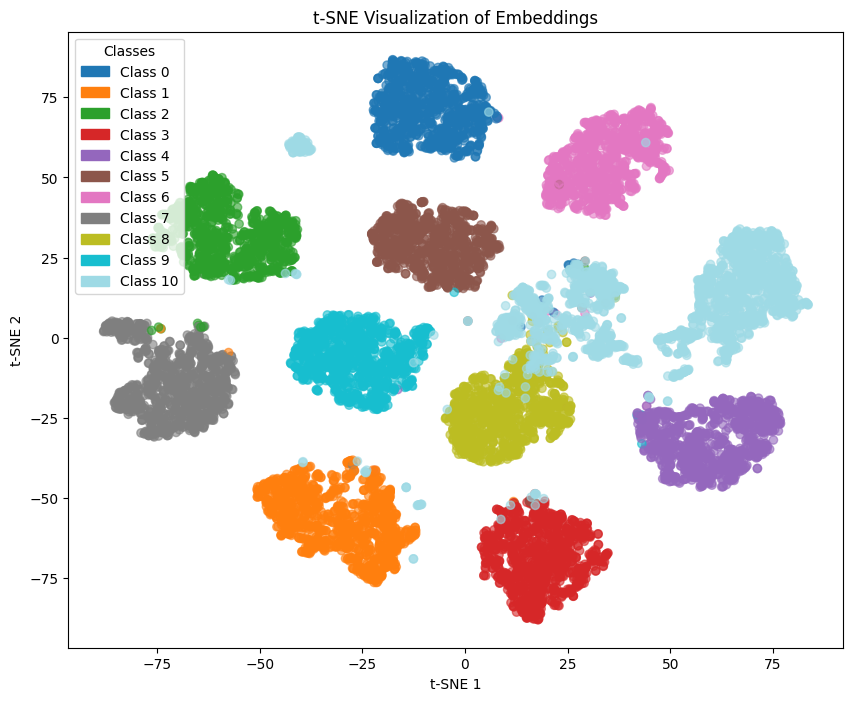

In [16]:
# ========================================
print("\n========================================")
print("    Generating t-SNE Visualization... ")
print("========================================\n")

visualize_embeddings(model, osr_loader, device)

## 6.7. ROC Curve


    Generating ROC Curve... 



Computing ROC Curve:   0%|          | 0/94 [00:00<?, ?it/s]

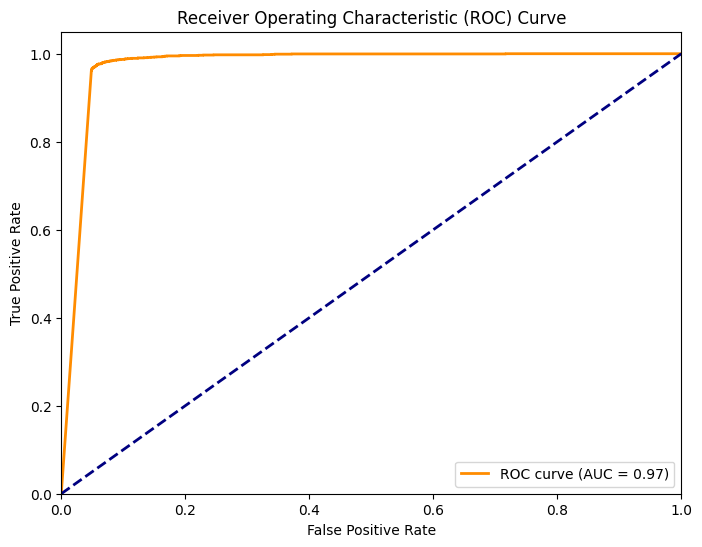

In [17]:
def plot_roc_curve(model, osr_loader, device):
    """
    Plots the ROC curve for distinguishing known vs unknown samples.
    """
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data, target in tqdm(osr_loader, desc="Computing ROC Curve"):
            data, target = data.to(device), target.to(device)
            outputs = model(data)  # Get logits
            probs = torch.softmax(outputs, dim=1)[:, 10]  # Get probability of 'Unknown' class

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend((target == 10).cpu().numpy())  # 1 for unknown, 0 for known

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Section 6.7 - Generate and display the ROC curve
print("\n========================================")
print("    Generating ROC Curve... ")
print("========================================\n")
plot_roc_curve(model, osr_loader, device)

# 7. Evaluation - Unknown Dataset

In [18]:
# 1. Empty dataset placeholder for the OSR evaluation
osr_dataset = []

# 2. Combined dataset that (MNIST test set + ood dataset) (automatically transforms ood data set)
final_osr_dataset = CombinedDataset(
    mnist=test_dataset,
    ood=osr_dataset,
    transform_ood=ood_transform  # Will be applied to ood dataset
)

# 3. Create dataloader
osr_loader = DataLoader(
    final_osr_dataset,
    shuffle=False,
    **loader_kwargs
)

# 4. Evaluate
if eval_mode:
    # Load model weights
    checkpoint = torch.load('complete_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    # ========================================
    print("\n==========================================================================")
    print("      Evaluating OSR Model with a given OOD dataset (placeholder)...")
    print("==========================================================================\n")

    acc_mnist, acc_ood, acc_total = eval_model(model, osr_loader, device)
    print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
    print(f'OOD Accuracy: {acc_ood*100:.2f}%')
    print(f'Total Accuracy: {acc_total*100:.2f}%')

    # ========================================
    print("\n==========================================================================")
    print("              OSR Results: Full & Binary Confusion Matrices...")
    print("==========================================================================\n")

    _, _, _, osr_preds, osr_labels = evaluate_osr(model, osr_loader, device)
    plot_confusion_matrices(osr_preds, osr_labels, baseline=False, accuracy=acc_total * 100)